In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from random import random
from keras.datasets import cifar10
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
import cv2
from PIL import Image

In [3]:
#region DataPreprocessing
#Load Data with Built in Datasaet from Keras
(train_x_input, train_y_labels), (test_x_input, test_y_labels) = cifar10.load_data()
# Explore the shapes and types of the loaded data
data_shapes = {
    "train_images": train_x_input.shape,
    "train_labels": train_y_labels.shape,
    "test_images": test_x_input.shape,
    "test_labels": test_y_labels.shape
}
#Normalize the Images
train_x_input = train_x_input.astype('float32') / 255.0
test_x_input = test_x_input.astype('float32') / 255.0
#one hot encoding
one_hot_train_labels = tf.keras.utils.to_categorical(train_y_labels, num_classes=10)
one_hot_test_labels = tf.keras.utils.to_categorical(test_y_labels, num_classes=10)
#endregion

In [4]:

#region Model Building and Configuration
model = Sequential()
# Convolutional Layers
model.add(Conv2D(50, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(72, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten the data
model.add(Flatten())
#Dense Layers
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout added after dense layers
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout added after dense layers
#Output final layer
model.add(Dense(10, activation='softmax'))
#Model Configuration
lr = 0.001  # tried 0.01, 0.005, but 0.001 gave best results
#0.001 Test - Loss: 2.4030191898345947, Accuracy: 0.5291000008583069
#0.01 Test - Loss: 5.0790863037109375, Accuracy: 0.2207999974489212
#0.005 Loss: 2.8926467895507812, Accuracy: 0.4887000024318695
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
#endregion

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 50)        1400      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 50)        200       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 50)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 72)        32472     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 72)        288       
 chNormalization)                                                
                                                        

In [5]:
#region Model Training
#Splitting data
x_train, x_val, y_train, y_val = train_test_split(train_x_input, one_hot_train_labels, test_size=0.2, random_state=50)
tensorboard_log = tf.keras.callbacks.TensorBoard(log_dir='logs')
#implement early stopping to prevent overfitting
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)
hist = model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_val, y_val), callbacks=[tensorboard_log,early_stop_callback])
#endregion

Epoch 1/10
400/400 [==============================] - 46s 113ms/step - loss: 6.9300 - accuracy: 0.4336 - val_loss: 6.4272 - val_accuracy: 0.1014
Epoch 2/10
400/400 [==============================] - 46s 114ms/step - loss: 2.6177 - accuracy: 0.5738 - val_loss: 2.5429 - val_accuracy: 0.5303
Epoch 3/10
400/400 [==============================] - 41s 102ms/step - loss: 2.2488 - accuracy: 0.6144 - val_loss: 2.4026 - val_accuracy: 0.5319
Epoch 4/10
400/400 [==============================] - 41s 102ms/step - loss: 2.1226 - accuracy: 0.6311 - val_loss: 2.1219 - val_accuracy: 0.6061
Epoch 5/10
400/400 [==============================] - 40s 101ms/step - loss: 2.0928 - accuracy: 0.6398 - val_loss: 2.8965 - val_accuracy: 0.4612
Epoch 6/10
400/400 [==============================] - 40s 100ms/step - loss: 2.0536 - accuracy: 0.6511 - val_loss: 1.9784 - val_accuracy: 0.6631
Epoch 7/10
400/400 [==============================] - 41s 101ms/step - loss: 2.0480 - accuracy: 0.6535 - val_loss: 2.0776 - val_ac

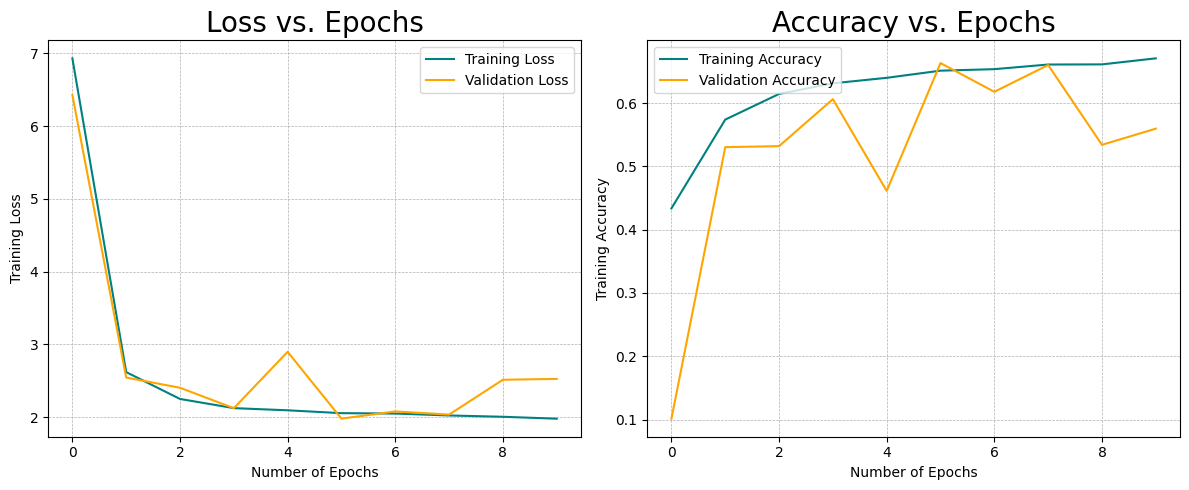

313/313 - 3s - loss: 2.5226 - accuracy: 0.5533 - 3s/epoch - 10ms/step
1563/1563 - 15s - loss: 2.4455 - accuracy: 0.5733 - 15s/epoch - 9ms/step
Test - Loss: 2.5226457118988037, Accuracy: 0.5533000230789185
Training - Loss: 2.4455318450927734, Accuracy: 0.5733399987220764


In [6]:

#region Model Evaluation
#Plotting Model Learning
# Create a figure with two subplots in a single row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# First subplot (Loss vs. Epochs)
ax1.plot(hist.history['loss'], color='teal', label='Training Loss')
ax1.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('Loss vs. Epochs', fontsize=20)
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Training Loss')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc="upper right")
# Second subplot (Accuracy vs. Epochs)
ax2.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('Accuracy vs. Epochs', fontsize=20)
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Training Accuracy')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend(loc="upper left")
# Adjust the layout
plt.tight_layout()
# Show the figure with both subplots
plt.show()
# Evaluate the model on the test dataset
loss_test, accuracy_test = model.evaluate(test_x_input, one_hot_test_labels, verbose=2)
loss_train, accuracy_train = model.evaluate(train_x_input, one_hot_train_labels, verbose=2)
print(f'Test - Loss: {loss_test}, Accuracy: {accuracy_test}')
print(f'Training - Loss: {loss_train}, Accuracy: {accuracy_train}')
#endregion


# Happy Sad Image Recognition
## 1. Setting up Depdencies

In [7]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Admin\AppData\Local\Temp\pip-install-s7y0r495\tensorflow-gpu_9e818e4c63dc41c5948ce7a632ef40d6\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not buil

In [8]:
!pip list

Package                      Version
---------------------------- --------------------
absl-py                      2.0.0
anyio                        3.7.1
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           3.2.0
cloudpickle                  2.2.1
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7.post1
decorator                    5.1.1
defusedxml                   0.7.1
executing            

In [9]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

C:\Users\Admin\AppData\Local\Temp\ipykernel_17184\1236592227.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [10]:
#dynamically allocate GPU memory as required
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [11]:
#Cleaning images that do not belong to the same format
data_source = 'C:\\Users\\Admin\\Desktop\\Image Classification\\data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Iterate over subdirectories (image classes) in the data source directory
for image_class in os.listdir(data_source):
    class_dir = os.path.join(data_source, image_class)
    
    # Iterate over image files in each class directory
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        
        try:
            # Attempt to read the image using OpenCV
            img = cv2.imread(image_path)
            
            # Check the image's file type using imghdr
            image_type = imghdr.what(image_path)
            
            # If the detected image type is not in the allowed extensions, remove the image
            if image_type not in image_exts:
                print(f'Image not in ext list: {image_path}')
                os.remove(image_path)
        except Exception as e:
            # Handle exceptions when reading or processing the image
            print(f'Issue with image: {image_path}')
            # Uncomment the line below to remove problematic images
            # os.remove(image_path)


## Exploring the Dataset

Found 305 files belonging to 2 classes.


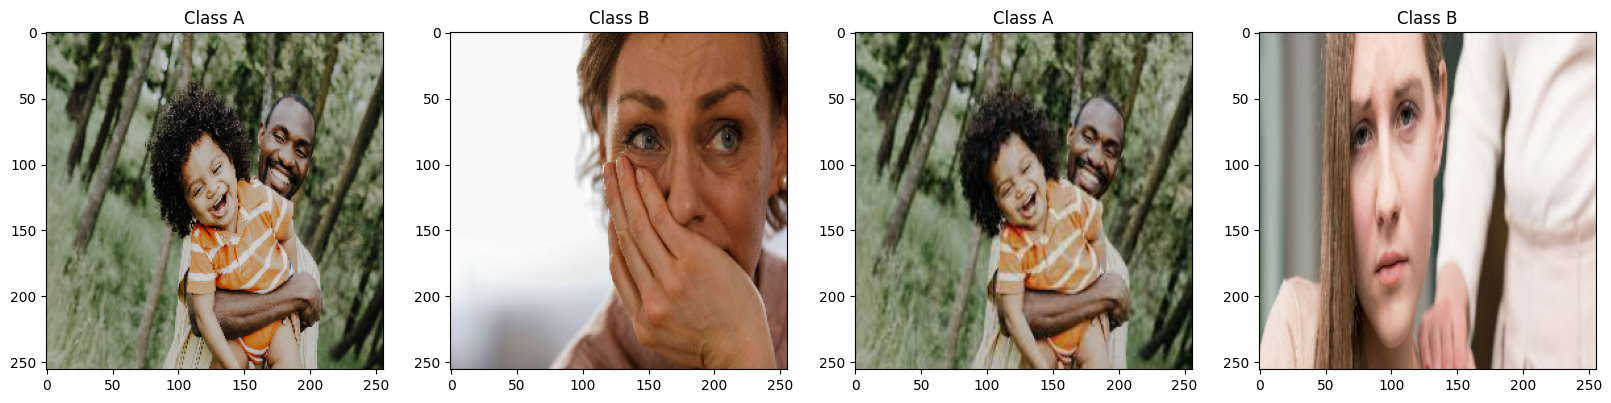

In [12]:
# Create a TensorFlow dataset from the directory
data = tf.keras.utils.image_dataset_from_directory(data_source)

# Get an iterator to access the data as NumPy arrays
data_iterator = iter(data)

# Get the first batch of data
batch = next(data_iterator)

# Create a subplot with 4 images per row
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Iterate over the images in the batch
for idx, img in enumerate(batch[0][:4]):
    # Convert the TensorFlow tensor to a NumPy array and then to int
    img_np = img.numpy().astype(int)
    
    # Check if the label is valid and set a meaningful title
    label = batch[1][idx]
    if label == 0:
        title = "Class A"
    elif label == 1:
        title = "Class B"
    # Add more conditions for other classes as needed
    
    # Display the image with the meaningful title
    ax[idx].imshow(img_np)
    ax[idx].set_title(title)

# Show the plot
plt.show()

## Scaling the Data

In [13]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[0.93333334, 0.93333334, 0.93333334],
          [0.93333

##Splitting the Data - Train, Eval, Test

In [14]:
# Define the proportions for the split
train_fraction = 0.7
val_fraction = 0.2
test_fraction = 0.1

# Shuffle the dataset
data = data.shuffle(len(data), seed=42, reshuffle_each_iteration=False)

# Split the dataset
num_samples = len(data)
train_size = int(train_fraction * num_samples)
val_size = int(val_fraction * num_samples)

# Create the training set
train = data.take(train_size)

# Create the validation set
val = data.skip(train_size).take(val_size)

# Create the test set
test = data.skip(train_size + val_size)

## Building NN Model

In [15]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_5 (Bat  (None, 125, 125, 32)      128       
 chNormalization)                                                
                                                      

## Training

In [17]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


7/7 [==============================] - 7s 803ms/step - loss: 4.6094 - accuracy: 0.6986 - val_loss: 1.1282 - val_accuracy: 0.7031
Epoch 2/20
7/7 [==============================] - 6s 744ms/step - loss: 2.0919 - accuracy: 0.7656 - val_loss: 1.3603 - val_accuracy: 0.5469
Epoch 3/20
7/7 [==============================] - 6s 766ms/step - loss: 1.3330 - accuracy: 0.8804 - val_loss: 1.2739 - val_accuracy: 0.5156
Epoch 4/20
7/7 [==============================] - 6s 723ms/step - loss: 1.1283 - accuracy: 0.8852 - val_loss: 1.3735 - val_accuracy: 0.6094
Epoch 5/20
7/7 [==============================] - 6s 787ms/step - loss: 0.8393 - accuracy: 0.9330 - val_loss: 1.6197 - val_accuracy: 0.5938
Epoch 6/20
7/7 [==============================] - 6s 807ms/step - loss: 0.8181 - accuracy: 0.9569 - val_loss: 1.4313 - val_accuracy: 0.6250
Epoch 7/20
7/7 [==============================] - 7s 834ms/step - loss: 0.7515 - accuracy: 0.9522 - val_loss: 1.2203 - val_accuracy: 0.7031
Epoch 8/20
7/7 [===============

## Plotting Performance

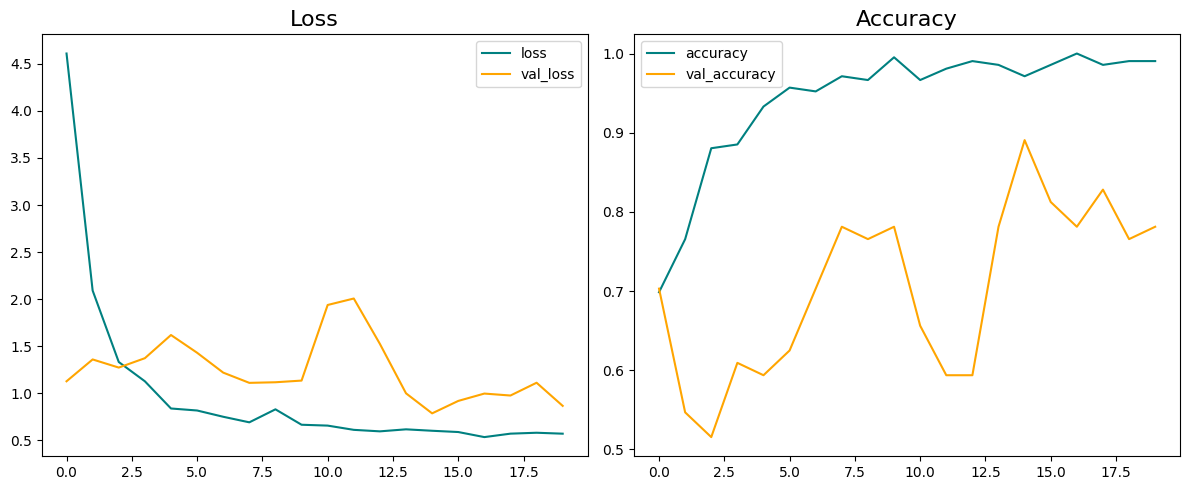

In [18]:
import matplotlib.pyplot as plt
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot loss in the first subplot
axs[0].plot(hist.history['loss'], color='teal', label='loss')
axs[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss', fontsize=16)
axs[0].legend(loc="upper right")
# Plot accuracy in the second subplot
axs[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy', fontsize=16)
axs[1].legend(loc="upper left")

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure with both subplots
plt.show()


## Evaluate

In [19]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Initialize lists to store evaluation results
precision_scores = []
recall_scores = []
accuracy_scores = []

# Evaluate the model on the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    
    # Convert probabilities to binary predictions (0 or 1)
    y_pred = np.round(yhat)
    
    # Calculate precision, recall, and accuracy for the batch
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    
    # Append the scores to the respective lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

# Calculate the mean scores over all batches
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_accuracy = np.mean(accuracy_scores)

# Display the evaluation results as a formatted string
evaluation_results = f"Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, Accuracy: {mean_accuracy:.4f}"
print(evaluation_results)


1/1 [==============================] - 0s 230ms/step
Precision: 0.8000, Recall: 0.7059, Accuracy: 0.7500


## Testing the Model

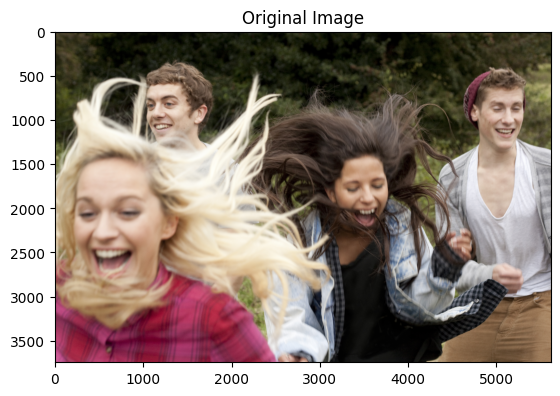

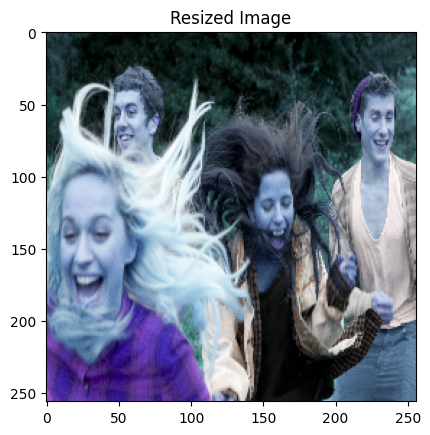

1/1 [==============================] - 0s 76ms/step
Predicted class is Sad


In [20]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load and display the original image
img = cv2.imread('testing-happy.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

# Resize the image to 256x256 pixels
resize = tf.image.resize(img, (256, 256))
resize = resize.numpy().astype(np.uint8)

# Display the resized image
plt.imshow(resize)
plt.title('Resized Image')
plt.show()

# Preprocess the resized image and make predictions
resize_normalized = resize / 255.0
yhat = model.predict(np.expand_dims(resize_normalized, 0))

# Determine the predicted class based on the model's output
predicted_class = 'Sad' if yhat > 0.5 else 'Happy'

# Display the prediction
print(f'Predicted class is {predicted_class}')
